In [1]:
import numpy as np
from typing import List
from networkx import DiGraph
from typing import Callable
from matplotlib import pyplot as plt
from typing import List
import networkx as nx


In [2]:
class Neuron:
    _graph: DiGraph
    # _value: float | None

    counter: int = 0

    def __init__(self, graph: DiGraph, value: float = None):
        self._graph = graph
        self._value = value

    def get_value(self) -> float:
        pass

    def clear_value(self):
        self._value = None

    def __str__(self):
        result = self._value if self._value is not None else 'x'
        i: int = Neuron.counter
        Neuron.counter += 1
        return f'{i}_ {result}'


In [3]:
class NeuronInput(Neuron):

    def get_value(self) -> float:
        if self._value is None:
            raise Exception("Input node has no value")
        return self._value

    def set_value(self, value: float):
        self._value = value


In [4]:
class NeuronPerceptron(Neuron):
    activation_function: Callable[[float], float]
    weight_bias: float

    def __init__(self, graph: DiGraph, weight_bias: float):
        super().__init__(graph)
        self.weight_bias = weight_bias
        self.activation_function = lambda x: 1 / (1 + np.exp(-x))

    def get_value(self) -> float:
        if self._value is None:
            self._value = self.weight_bias
            in_edges = self._graph.in_edges(self, data=True)
            for in_edge in in_edges:
                prev_neuron: Neuron = in_edge[0]
                prev_neuron_value: float = prev_neuron.get_value()
                in_edge_weight: float = in_edge[2]['weight']
                self._value += prev_neuron_value * in_edge_weight

        self._value = self.activation_function(self._value)

        return self._value


In [5]:
class Network:
    _graph: DiGraph
    _neurons: List[List[Neuron]]
    _neurons_input: List[NeuronInput]  # _neurons[0]
    _neurons_output: List[NeuronPerceptron]  # _neurons[-1]

    def __init__(self, topology: List[int]):
        topology_len: int = len(topology)
        if topology_len < 2:
            raise Exception("Network must have at least 2 layers")
        self._graph = DiGraph()
        self._neurons = []
        # Input Neuron:
        self._neurons_input = []
        input_layer_count: int = topology[0]
        for i in range(input_layer_count):
            node_input: NeuronInput = NeuronInput(self._graph)
            self._graph.add_node(node_input, pos=(0, -i))
            self._neurons_input.append(node_input)
        self._neurons.append(self._neurons_input)
        # Hidden Neuron:
        for t in range(1, topology_len - 1):
            i_layer_count = topology[t]
            neurons_layer_i = []
            for i in range(i_layer_count):
                neuron: NeuronPerceptron = NeuronPerceptron(self._graph, self.generate_weight())
                self._graph.add_node(neuron, pos=(t, -i))
                neurons_layer_i.append(neuron)
                self.connect_neuron_with_layer(neuron, i - 1)
            self._neurons.append(neurons_layer_i)
        # Output Neuron:
        self._neurons_output = []
        output_layer_count: int = topology[-1]
        for i in range(output_layer_count):
            neuron: NeuronPerceptron = NeuronPerceptron(self._graph, self.generate_weight())
            self._graph.add_node(neuron, pos=(topology_len - 1, -i))
            self._neurons_output.append(neuron)
            self.connect_neuron_with_layer(neuron, -1)

    def propagate(self, features: List[float]) -> List[float]:
        count: int = len(features)
        if count != len(self._neurons_input):
            raise Exception('Error')
        # Clear neurons values:
        for layer in self._neurons:
            for neuron in layer:
                neuron.clear_value()
        # Set network input values:
        for i in range(count):
            f: float = features[i]
            neuron: NeuronInput = self._neurons_input[i]
            neuron.set_value(f)

        return [o_neuron.get_value() for o_neuron in self._neurons_output]

    def generate_weight(self) -> float:
        return np.random.uniform(-.5, .5)

    def generate_weights(self, count: int) -> List[float]:
        return [self.generate_weight() for _ in range(count)]

    def connect_neuron_with_layer(self, neuron: Neuron, layer_index: int):
        for neuron_prev in self._neurons[layer_index]:
            self._graph.add_edge(neuron_prev, neuron, weight=self.generate_weight())

    def draw(self):
        nx.draw(
            self._graph,
            with_labels=True,
            font_weight='bold',
            node_size=1000,
            node_color='green',
            pos=nx.get_node_attributes(self._graph, 'pos'),
        )
        plt.show()


Network Output [0.5784930883452074, 0.39911535972738443]


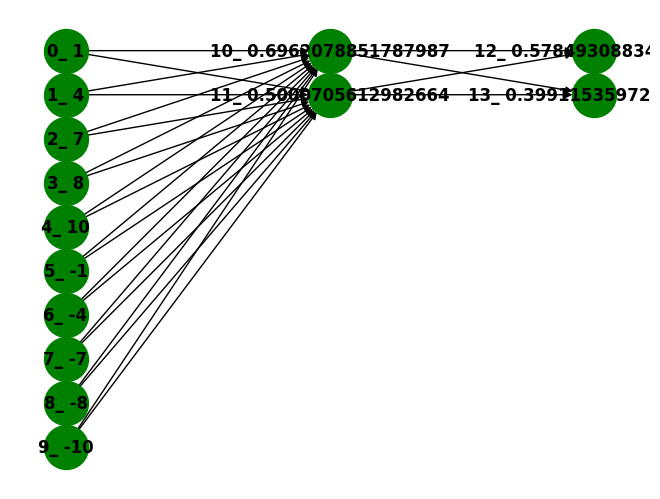

In [6]:
if __name__ == '__main__':
    np.random.seed(123)

    features: List[int] = [1, 4, 7, 8, 10, -1, -4, -7, -8, -10]

    network: Network = Network([10, 2, 2])
    print(f'Network Output {network.propagate(features)}')
    network.draw()